In [30]:
# pylint: disable=all
import logging
import tests
import numpy as np
import matplotlib.pyplot as plt
import quadtree_helper
from exactpack.solvers.riemann import IGEOS_Solver
import matplotlib.animation as animation

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s:%(module)s:%(funcName)s | %(message)s')
min_resolution = 16
max_resolution = 256
(cfg, target_time) = tests.sod_shock_tube(res=(max_resolution, max_resolution))

In [68]:
# def depth_formula_sod(x, y, max_depth, min_depth, center_x=0.5, center_y=0.5):
#     # Rotation matrix
#     # | cos(θ) -sin(θ) |
#     # | sin(θ)  cos(θ) |

#     count = 15
#     for i,a in enumerate(np.linspace(1.0, 1.5, count)):
#         theta = np.pi * a
#         M = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
#         center = np.array([center_x, center_y])
#         rot = ((np.array([x, y])) - 2.0 * center) @ M
#         # print(rot)

#         if rot[1] < 1/count:
#             return max_depth - (i%2 * 2)
    
#     return min_depth

def depth_formula_sod(x, y, max_depth, min_depth, center_x=0.5, center_y=0.5):
    # Rotation matrix
    # | cos(θ) -sin(θ) |
    # | sin(θ)  cos(θ) |

    theta = np.pi * 1.2
    M = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    center = np.array([center_x, center_y])
    rot = ((np.array([x, y])) - center) @ M + center
    # print(rot)

    count = 10
    for i,v in enumerate(np.linspace(0.0, 1.0, count)):
        if rot[1] < v:
            return max_depth - (i%2 * 2)
    
    return min_depth

In [69]:
tests.gen_quadtree(1,1, int(np.log2(min_resolution)), int(np.log2(max_resolution)), max_resolution, depth_formula_sod)
sqmap = quadtree_helper.read_sqmatrix_from_file()
depth,_,_ = quadtree_helper.read_nodes_from_file()
depth = np.array(depth)

2025-01-26 21:37:56,594 | INFO:tests:gen_quadtree | Generating quadtree with min_depth=4, max_depth=8, max_resolution=256
2025-01-26 21:38:01,511 | INFO:tests:gen_quadtree | Generating helper constructs
2025-01-26 21:38:02,119 | INFO:tests:gen_quadtree | Leaf nodes: 36763, Virtual nodes: 1859
2025-01-26 21:38:02,120 | INFO:tests:gen_quadtree | Writing nodes to file
2025-01-26 21:38:02,163 | INFO:tests:gen_quadtree | Creating and writing square grid map to file
2025-01-26 21:38:02,404 | INFO:tests:gen_quadtree | Creating and writing boundary cell map to file
2025-01-26 21:38:02,417 | INFO:tests:gen_quadtree | Quadtree generation completed


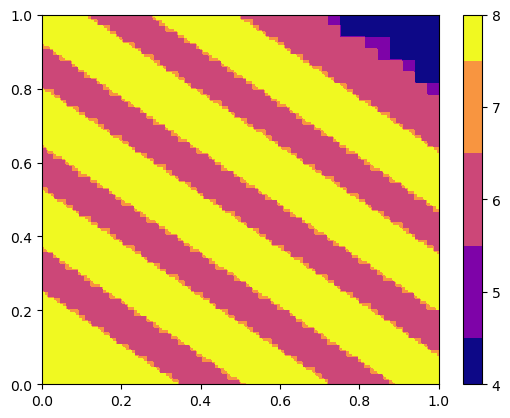

In [70]:
cmap = plt.get_cmap('plasma', np.max(depth[sqmap]) - np.min(depth[sqmap]) + 1)
contour = plt.contourf(depth[sqmap][::-1], extent=(0, 1, 0, 1), cmap=cmap,
                          vmin=np.min(depth[sqmap]) - 0.5, vmax=np.max(depth[sqmap]) + 0.5)

plt.colorbar(contour, ticks=np.arange(np.min(depth[sqmap]), np.max(depth[sqmap]) + 1))


In [71]:
space = tests.Quadtree(cfg, use_torch=False)
sim = tests.no_tvd_simulation(space)

(states,times) = sim.run(target_time=target_time,checkpoint_freq=20, no_iter=False)
states = np.array([space.to_grid(state) for state in states])


2025-01-26 21:38:10,343 | INFO:sim_upwind_simple:run | Max number of iterations: 72916
2025-01-26 21:38:10,411 | INFO:sim_upwind_simple:run | iter: 0, dt: 0.0007003292632818713, total: 0.0007003292632818713 [Saved]
2025-01-26 21:38:10,483 | INFO:sim_upwind_simple:run | iter: 1, dt: 0.00045858918854127853, total: 0.0011589184518231497
2025-01-26 21:38:10,550 | INFO:sim_upwind_simple:run | iter: 2, dt: 0.000438894427337387, total: 0.0015978128791605368
2025-01-26 21:38:10,631 | INFO:sim_upwind_simple:run | iter: 3, dt: 0.0004314056688996398, total: 0.0020292185480601764
2025-01-26 21:38:10,693 | INFO:sim_upwind_simple:run | iter: 4, dt: 0.0004280694853370156, total: 0.002457288033397192
2025-01-26 21:38:10,754 | INFO:sim_upwind_simple:run | iter: 5, dt: 0.00041565855622534205, total: 0.002872946589622534
2025-01-26 21:38:10,819 | INFO:sim_upwind_simple:run | iter: 6, dt: 0.000408418651689589, total: 0.0032813652413121227
2025-01-26 21:38:10,883 | INFO:sim_upwind_simple:run | iter: 7, dt:

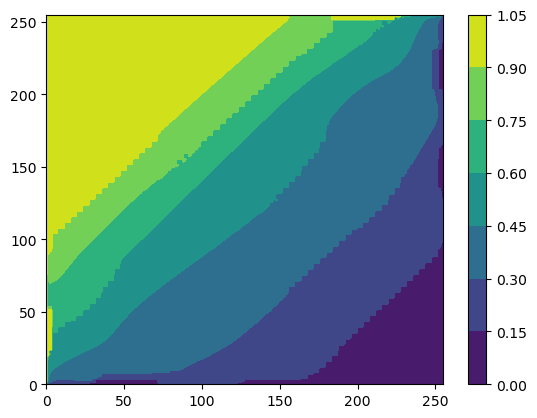

In [75]:
plt.contourf(states[-1, 0])
plt.colorbar()

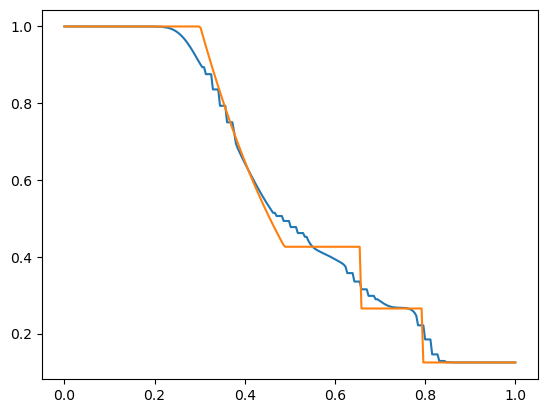

In [73]:
cp = states[-1,0].copy()
idx = np.diag_indices(cp.shape[0])

x = (np.linspace(0., 1., states[0][0].shape[0]))
y = (cp[::-1][idx])

plt.plot(x,y, label=f"Quadtree")

xvec = x
solver = IGEOS_Solver( 
                    rl=1.0,   ul=0.,   pl=1.0,  gl=1.4,
                    rr=0.125, ur=0.,   pr=0.1,  gr=1.4,
                    xmin=0.,  xd0=0.5, xmax=1., t=0.168
                )
solu = solver._run(xvec, t=0.168)


plt.plot(xvec, solu["density"], label="Exact Solution")
